In [131]:
import os
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 16}

plt.rc('font', **font)

font = {'family' : 'serif',
        #  'size'   : 26,
         'serif':  'cmr10'
         }
plt.rc('font', **font)
# plt.rcParams.update({'font.size': 26})

def read_csvs(training_results):
    big_df: pd.DataFrame = None

    image_files_FINAL  = [file[12:-4] for file in os.listdir(f"{training_results}")]
    for f in image_files_FINAL:
        if f.split('__') == ['']:
            continue
        # print(f.split('__'))
        architecture, encoder, loss, encoder_freeze, dataset = f.split('__')
        df = pd.read_csv(f"{training_results}/best_model__{architecture}__{encoder}__{loss}__{encoder_freeze}__{dataset}.csv", index_col=0)
        df['architecture'] = architecture
        df['encoder'] = encoder
        df['loss_func'] = loss
        df['dataset'] = dataset
        if type(big_df) == 'NoneType':
            big_df = df
        else:
            big_df = pd.concat((big_df, df))
    return big_df

loss_color_dict = {
    'JaccardLoss': '#e6194b',
    'BCEJaccardLoss': '#000075',
    'DiceLoss': '#3cb44b',
    'BCEDiceLoss': '#4363d8',
    'BCELoss': '#f58231',
    'FocalLoss': '#000000',
    'BinaryLovaszLoss': '#46f0f0',
}

architecture_color_dict = {
    'Unet': '#e6194b',
    'Linknet': '#000075',
    'PSPNet': '#4363d8',
    'MAnet': '#f58231',
    'DeepLabV3Plus': '#000000',
    'FPN': '#46f0f0',
    'PAN': '#f032e6',
    'UnetPlusPlus':'#9a6324'
}

encoder_color_dict = {
    'resnet101': '#e6194b',
    'resnet34': '#000075',
    'efficientnet-b2': '#3cb44b',
    'efficientnet-b1': '#4363d8',
    'xception41': '#f58231',
}

dataset_feature_color_dict = {
    'two_channel': '#e6194b',
    'normal': '#000075',
    'gradient': '#3cb44b',
}

In [132]:
def sort_data(big_df, y_column, filters=None):
    big_df_copy = big_df.copy(deep=True)
    if filters != None:
        big_df_copy.query(filters, inplace=True)

    data_sorted = []
    for data in big_df_copy.groupby(['architecture', 'encoder', 'loss_func', 'freeze_encoder', 'dataset']):
        # architecture, encoder, loss, freeze, dataset = data[0]
        data_sorted.append((data, np.max(data[1][y_column]))) # data, highest score 
    return data_sorted

def create_table(big_df: pd.DataFrame, axs, row, col, y_column, data_name, table_data_name, text_letter=None, filters=None):
    data_sorted = sort_data(big_df, y_column, filters)
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    axs[row, col].axis('off')
    axs[row, col].table(cellText=max_val_ious,
                    # rowLabels=rows,
                    # rowColours=colors,
                    colLabels=(table_data_name, "Val IoU"),
                    loc='center')
    if text_letter is not None:
        axs[row,col].text(.025, .925, text_letter, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=axs[row,col].transAxes)


def create_sub_fig(big_df, axs: plt.Axes, row, col, y_column, y_column_name, plot_title, data_name, color_dict,
                   text_letter=None, x_column=None, x_column_name="Epochs", legend=True, loc='lower right', 
                   filters=None, legend_font_size=10, letter_font_size=20, title=False, **plot_options):
    if axs.shape == (2, 2): # Handle different shape plots
        index = (row,col)
    elif axs.shape == (2,):
        index = col
    else:
        raise Exception("Unknown dims. Shape:", axs.shape)

    data_sorted = sort_data(big_df, y_column, filters)

    for i, data in enumerate(sorted(data_sorted, key=lambda x: x[1], reverse=True)):
        # print(data[0][1][y_column][:20])
        architecture, encoder, loss, freeze, dataset = data[0][0] 
        if x_column == None:
            x_column_ = list(range(len(data[0][1][y_column][:20])))
        else:
            x_column_ = data[0][1][x_column][:20]
        
        axs[index].plot(x_column_, data[0][1][y_column][:20], label=f"{i+1}. {data[0][0][data_name]}", color=color_dict[data[0][0][data_name]]) #, 'o', ls='-', ms=4)

    if title:
        axs[index].set_title(plot_title)
    axs[index].set_ylabel(y_column_name)
    axs[index].set_xlabel(x_column_name)
    axs[index].legend(loc=loc, fontsize=legend_font_size)
    axs[index].xaxis.set_major_locator(MaxNLocator(integer=True))
    if not legend:
        axs[index].get_legend().remove()
    if text_letter is not None:
        axs[index].text(.03, .925, text_letter, fontsize=letter_font_size, horizontalalignment='center', verticalalignment='center', transform=axs[index].transAxes)


# Dataset Feature

[('two_channel', 0.89736), ('gradient', 0.89127), ('normal', 0.88595)]


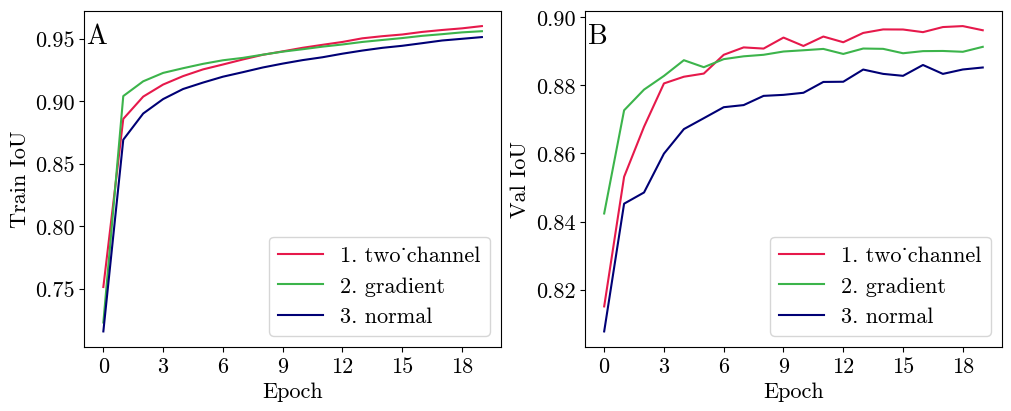

In [138]:
def plot_data_ARCHITECTURE(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 4 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict = dataset_feature_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Jaccard Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val  Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=16)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=16)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Dataset Feature", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)

    return fig


feature_engieering = read_csvs("./TRAINING_RESULTS_new/feature_engineering")    
# IoU
loss_train_fig = plot_data_ARCHITECTURE(feature_engieering)
loss_train_fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.1/select_feature.svg")
# loss_train_fig.show()
# Select_encoder_df

# Arch

[('DeepLabV3Plus', 0.96677), ('MAnet', 0.95909), ('FPN', 0.95568), ('PAN', 0.94938), ('PSPNet', 0.93177), ('Linknet', 0.92084), ('UnetPlusPlus', 0.92065), ('Unet', 0.89736)]


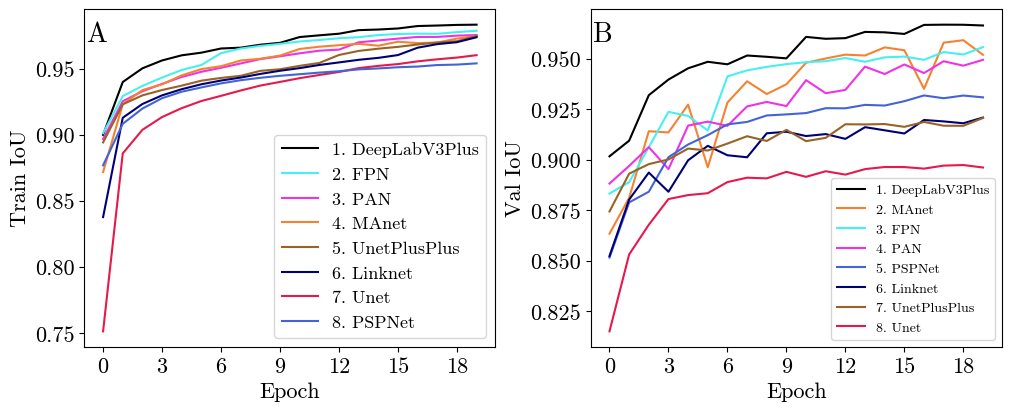

In [139]:
def plot_data_ARCHITECTURE(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 0 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict = architecture_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Jaccard Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", x_column_name="Epoch")
    
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=13)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=10)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Architectures", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    return fig


Select_architecture_df = read_csvs("./TRAINING_RESULTS_new/Select_architecture")    
# IoU
loss_train_fig = plot_data_ARCHITECTURE(Select_architecture_df)
loss_train_fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.1/select_architecture.svg")
# loss_train_fig.show()
# Select_encoder_df

# Encoders

[('efficientnet-b2', 0.97001), ('efficientnet-b1', 0.96999), ('resnet34', 0.96677), ('resnet101', 0.96381), ('xception41', 0.96082)]
[('resnet101', 0.89877), ('efficientnet-b2', 0.89463), ('efficientnet-b1', 0.89379), ('resnet34', 0.89062), ('xception41', 0.86632)]


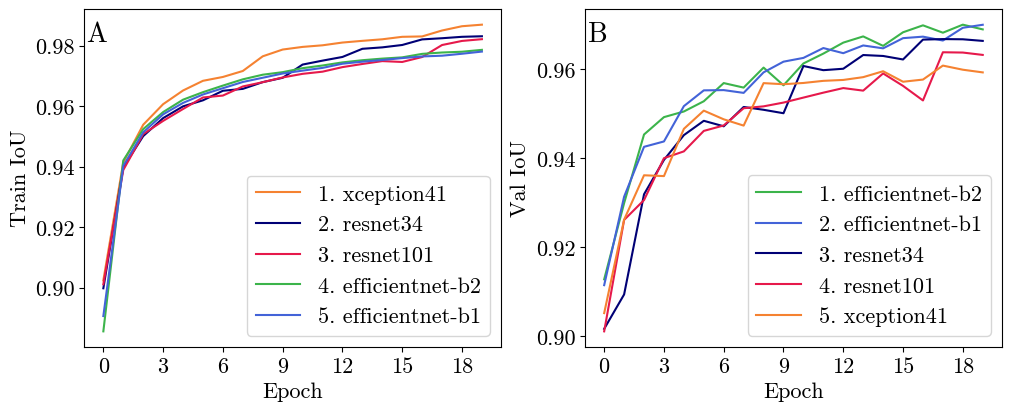

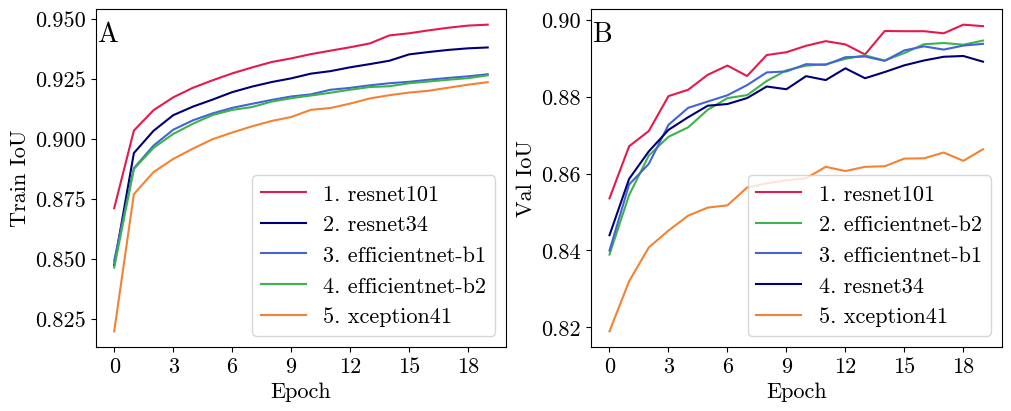

In [140]:
def plot_data_Encoder(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 1 # == Loss
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')
    color_dict = encoder_color_dict

    # filter = "freeze_encoder == False & encoder != 'resnetv2_50' & encoder != 'resnetv2_101'"
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Jaccard Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    
    # Table val score
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Architectures", text_letter="B")

    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=16)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=16)
    
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    return fig


Select_encoder_df = read_csvs("./TRAINING_RESULTS_new/Select_encoder")    
Select_encoder_df.query("freeze_encoder == False & encoder != 'resnetv2_50' & encoder != 'resnetv2_101'", inplace=True)

loss_train_fig = plot_data_Encoder(Select_encoder_df)
loss_train_fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.1/select_encoder.svg")

Select_encoder_df = read_csvs("./TRAINING_RESULTS_new/Select_encoder")    
Select_encoder_df.query("freeze_encoder == True & encoder != 'resnetv2_50' & encoder != 'resnetv2_101'", inplace=True)
loss_train_fig = plot_data_Encoder(Select_encoder_df)
loss_train_fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.1/select_encoder_frozen.svg")

[('BCELoss', 0.97188), ('DiceLoss', 0.97164), ('BCEDiceLoss', 0.97132), ('BCEJaccardLoss', 0.97083), ('JaccardLoss', 0.97001), ('FocalLoss', 0.96988), ('BinaryLovaszLoss', 0.95916)]


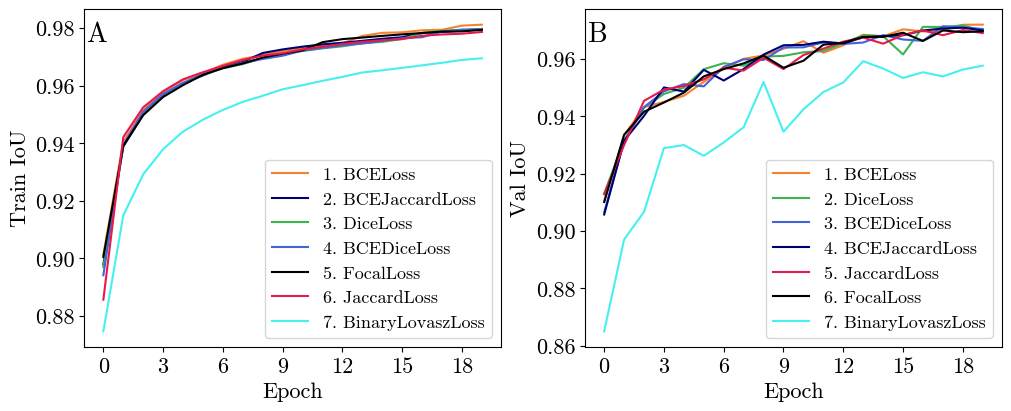

In [141]:
def plot_data_ARCHITECTURE(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 2 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict=loss_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=13)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=13)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Loss function", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    
    return fig


Select_encoder_df = read_csvs("./TRAINING_RESULTS_new/selecting_loss")
# IoU
loss_train_fig = plot_data_ARCHITECTURE(Select_encoder_df)
loss_train_fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.1/select_loss.svg")
# loss_train_fig.show()
# Select_encoder_df
# Select_encoder_df[['loss_func', 'val_iou_score']]